In [1]:
import os
import supervision as sv
import ultralytics
from ultralytics import YOLO
from IPython import display
import cv2
import torch
import numpy as np
import time
from typing import Callable

In [2]:
from supervision import VideoInfo, VideoSink

In [3]:
def process_video(
    source_path: str,
    target_path: str,
    callback: Callable[[np.ndarray, int], np.ndarray],
    start: int = 0,
    end: int = 0,
    stride: int = 1,
) -> None:
    """
    Process a video file by applying a callback function on each frame
        and saving the result to a target video file.

    Args:
        source_path (str): The path to the source video file.
        target_path (str): The path to the target video file.
        callback (Callable[[np.ndarray, int], np.ndarray]): A function that takes in
            a numpy ndarray representation of a video frame and an
            int index of the frame and returns a processed numpy ndarray
            representation of the frame.

    Examples:
        ```python
        import supervision as sv

        def callback(scene: np.ndarray, index: int) -> np.ndarray:
            ...

        process_video(
            source_path='...',
            target_path='...',
            callback=callback
        )
        ```
    """
    source_video_info = VideoInfo.from_video_path(video_path=source_path)
    with VideoSink(target_path=target_path, video_info=source_video_info) as sink:
        for index, frame in enumerate(
            sv.get_video_frames_generator(source_path, start=start, end=end, stride=stride)
        ):
            result_frame = callback(frame, index)
            sink.write_frame(frame=result_frame)

In [4]:
res = {
    "lost_track_buffer": [],
    "processing_time": [],
    "fps": [],
    "in_count": [],
    "out_count": [],
}

In [5]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device

device(type='mps')

In [6]:
# model = YOLO("yolov6s.yaml")
model = YOLO("yolo11s.pt")
# model
model = model.to(device)

In [7]:
resolution = '1280x720'
date = '15_04_25'
time_h = '7-8'
catalog = 'Golski'
video_name = f'Golski_{resolution}.mp4'

In [8]:
start = 0
end = 4200
stride = 5

In [9]:
SOURCE_VIDEO_PATH = f"/Users/grzegorzsmereczniak/Documents/MyPW/data/monitoring_pw/{date}/{time_h}/{catalog}/resized/{video_name}"
RESULTS_PATH = f"/Users/grzegorzsmereczniak/Documents/MyPW/results/monitoring_pw/{date}/{time_h}/{catalog}"

In [10]:
CLASS_NAMES_DICT = model.model.names

SELECTED_CLASS_NAMES = ['person']

SELECTED_CLASS_IDS = [
    {value: key for key, value in CLASS_NAMES_DICT.items()}[class_name]
    for class_name
    in SELECTED_CLASS_NAMES
]

In [11]:
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH, start=930, end=932, stride=stride)

box_annotator = sv.BoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(text_thickness=2, text_scale=1.5, text_color=sv.Color.BLACK)

iterator = iter(generator)
frame = next(iterator)

results = model(frame, conf=0.25, verbose=False, classes=[0])[0]

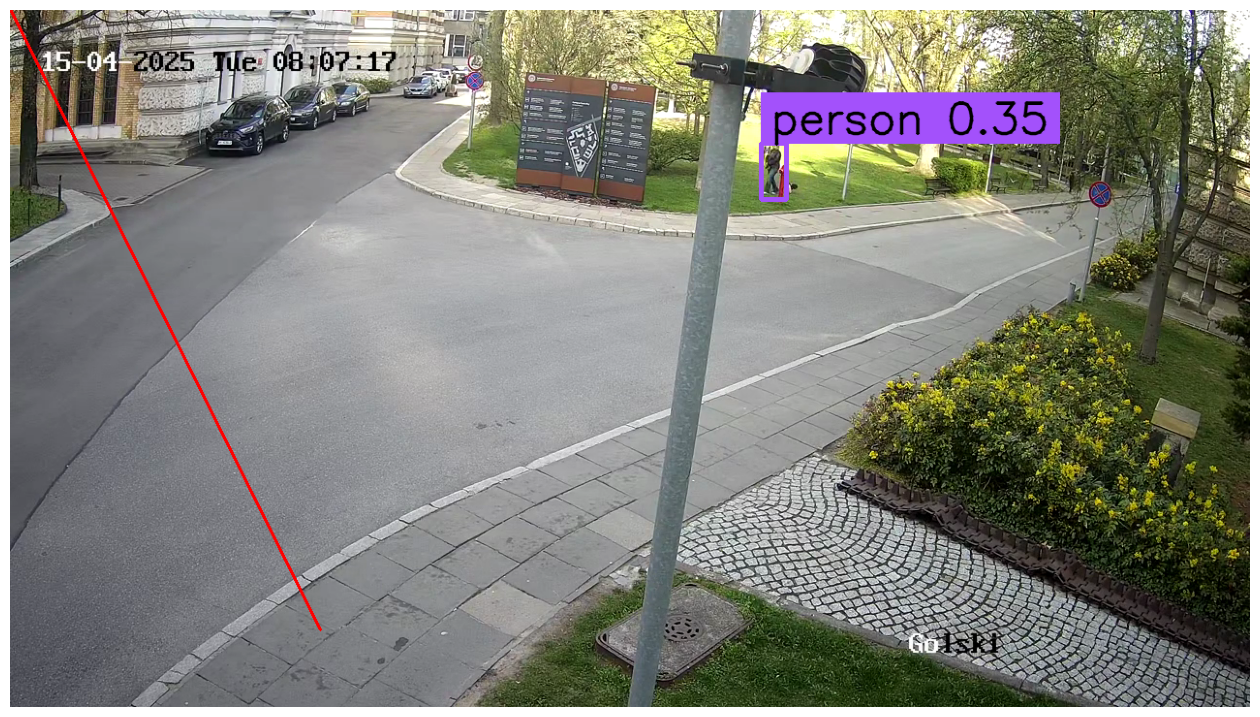

In [12]:
detections = sv.Detections.from_ultralytics(results)

detections = detections[np.isin(detections.class_id, SELECTED_CLASS_IDS)]

labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for confidence, class_id in zip(detections.confidence, detections.class_id)
]

annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)
annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

# ▶️ Add horizontal line
coord1 = (0, 0)
coord2 = (320, 640)
cv2.line(annotated_frame, coord1, coord2, color=(0, 0, 255), thickness=2)

# ▶️ Display the frame
%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

In [13]:
results = model(frame, verbose=False)[0]
results.boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.], device='mps:0')
conf: tensor([0.3453], device='mps:0')
data: tensor([[7.7583e+02, 1.3832e+02, 8.0109e+02, 1.9622e+02, 3.4527e-01, 0.0000e+00]], device='mps:0')
id: None
is_track: False
orig_shape: (720, 1280)
shape: torch.Size([1, 6])
xywh: tensor([[788.4590, 167.2734,  25.2607,  57.9001]], device='mps:0')
xywhn: tensor([[0.6160, 0.2323, 0.0197, 0.0804]], device='mps:0')
xyxy: tensor([[775.8286, 138.3233, 801.0894, 196.2234]], device='mps:0')
xyxyn: tensor([[0.6061, 0.1921, 0.6259, 0.2725]], device='mps:0')

In [14]:
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_info

VideoInfo(width=1280, height=720, fps=14, total_frames=26731)

In [15]:
LINE_START = sv.Point(*coord1)
LINE_END = sv.Point(*coord2)

In [16]:
# create LineZone instance, it is previously called LineCounter class
line_zone = sv.LineZone(start=LINE_START, end=LINE_END)

# create instance of BoxAnnotator, LabelAnnotator, and TraceAnnotator
box_annotator = sv.BoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(text_thickness=2, text_scale=1.5, text_color=sv.Color.BLACK)
trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=50)

# create LineZoneAnnotator instance
line_zone_annotator = sv.LineZoneAnnotator(thickness=4, text_thickness=4, text_scale=2, text_orient_to_line=True)

start_time = time.time()
video_name = f"stride_{stride}_{video_name}"

TARGET_VIDEO_PATH = os.path.join(RESULTS_PATH, f"{video_name}")

# create BYTETracker instance
byte_tracker = sv.ByteTrack(
    track_activation_threshold=0.25,
    lost_track_buffer=30,
    minimum_matching_threshold=0.8,
    frame_rate=video_info.fps,
    minimum_consecutive_frames=3)

byte_tracker.reset()

# define call back function to be used in video processing
def callback(frame: np.ndarray, index: int) -> np.ndarray:
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = detections[np.isin(detections.class_id, SELECTED_CLASS_IDS)]
    detections = byte_tracker.update_with_detections(detections)

    labels = [
        f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id, tracker_id
        in zip(detections.confidence, detections.class_id, detections.tracker_id)
    ]

    annotated_frame = frame.copy()
    annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=detections)
    annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

    # update line counter
    line_zone.trigger(detections)
    # return frame with box and line annotated result
    return line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

# process the whole video
process_video(
    source_path = SOURCE_VIDEO_PATH,
    target_path = TARGET_VIDEO_PATH,
    callback=callback,
    start=start,
    end=end,
    stride=stride
)

end_time = time.time()
elapsed_time = end_time - start_time

in_count = line_zone.in_count
out_count = line_zone.out_count

res['processing_time'].append(elapsed_time)
res['fps'].append(video_info.fps)
res['in_count'].append(in_count)
res['out_count'].append(out_count)

In [17]:
res

{'lost_track_buffer': [],
 'processing_time': [38.795334815979004],
 'fps': [14],
 'in_count': [0],
 'out_count': [0]}